# Yelp restaurant reviews - Capstone Project

http://drivendata.co/case-studies/using-yelp-reviews-to-flag-restaurant-health-risks/
https://www.yelp.com/dataset/documentation/main

This project is about predicting restaurant ratings from restaurants reviews and other characteristics of the businesses. I had to orginize data from 6 files and I end up 2 different datasets, the first one is the reviews gathered from Yelp documentation. It is a json file that I decode with the method JSONDecoder to read it. The second is more easy to read as it is a CSV file corresponding to business features I merged with the column business ID.

Initial variables for the different dataframes:

**Reviews DataFrame:

    -Bussiness_id : id unique to each bussines (string)
    -Text :  People reviews of the bussines (string)
    -Stars : Star rating  (integer)
    -DataR : Date when the review was posted (string)
    -Useful : Number of useful votes received (integer)
    -Funny : Number of funny votes received (integer)
    -Cool : Number of cool votes received (integer)


**Business DataFrame:

    -Business_id : 22 character unique string business id (string)
    -Name : Business's name (string)
    -Address : full address of the business (string)
    -City : Name of the city where the bussines is (string)
    -State : state code (string)
    -Postal code : The postal code (string)
    -Latitude : latitud (float)
    -Longitude : longitude (float)
    -Stars : star rating (float)
    -Review count : number of reviews (integer)
    -Is open : Indicating restaurant closed or open (integer)
    -Garage : Indicating restaurant has or not garage (integer)
    -Reservations : Indicating restaurant has possibility to make reservations or not(integer)
    -Credit card : Indicating restaurant has possibility to pay with CC or not (integer)
    ... (somo more attributes)
    -Categories: business categories (array of strings)




Initially I had 3 datasets: 
 -Violations dataset
 -Restaurants dataset
 -Reviews dataset

One interesting thing founded was that the Bussines_id from the reviews dataset doesn't match with the restaurant_id of the Violations dataset, so at the moment I could merge Violations Dataframe and Restaurants Dataframe by the Restaurant_id columns but not the third one corresponding to the Reviews Dataframe. I was looking for a way to merge it until I realized the businesses IDs didn't match at all because there were not related so I decided that my final aim will be:

To evaluate by sentimental analisis and NLP tools how the words(features) of the reviews gathered from yelp together with the business characteristics, help to predict the ratings of the restaurants.

In [85]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn import metrics
from sklearn.preprocessing import label_binarize


#WORD CLOUD
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#NLP
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import stop_words

#MODELING
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from imblearn.under_sampling import RandomUnderSampler 
from imblearn.over_sampling import RandomOverSampler
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, BaggingClassifier




# 1st --> PREPARING/CLEANING DATASETS

### Reviews dataset

In [2]:
with open('/Users/blancabenaventricart/Desktop/Capstone data/yelp_dataset/yelp_academic_dataset_review.json') as f:
    lines = []
    for x in range(5996996): 
        l = f.readline()
        lines.append(l)

In [3]:
d = json.JSONDecoder()
d

In [4]:
reviews = []
for line in lines:
    reviews.append(d.decode(line))

In [5]:
#reviews

In [6]:
bid = []
text_ = []
stars_ = []
date = []

for r in reviews:
    try:
        bid.append(r['business_id'])
    except:
        bid.append(np.nan)
    try:
        text_.append(r['text'])
    except:
        text_.append(np.nan)
    try:
        stars_.append(r['stars'])
    except:
        stars_.append(np.nan)
    try:
        date.append(r['date'])
    except:
        date.append(np.nan)


review_df = pd.DataFrame({'Business_id': bid, 'Text': text_, 'Stars': stars_,
                         'DateR':date}) 

In [7]:
review_df.head(5)

,Business_id,Text,Stars,DateR
0,iCQpiavjjPzJ5_3gPD5Ebg,The pizza was okay. Not the best I've had. I p...,2,2011-02-25
1,pomGBqfbxcqPv14c3XH-ZQ,I love this place! My fiance And I go here atl...,5,2012-11-13
2,jtQARsP6P-LbkyjbO1qNGg,Terrible. Dry corn bread. Rib tips were all fa...,1,2014-10-23
3,elqbBhBfElMNSrjFqW3now,Back in 2005-2007 this place was my FAVORITE t...,2,2011-02-25
4,Ums3gaP2qM3W1XcA5r6SsQ,Delicious healthy food. The steak is amazing. ...,5,2014-09-05


In [8]:
review_df.to_csv('review_df.csv')

In [2]:
review_df = pd.read_csv('review_df.csv')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
review_df.head()

,Unnamed: 0,Business_id,Text,Stars,DateR
0,0,iCQpiavjjPzJ5_3gPD5Ebg,The pizza was okay. Not the best I've had. I p...,2.0,2011-02-25
1,1,pomGBqfbxcqPv14c3XH-ZQ,I love this place! My fiance And I go here atl...,5.0,2012-11-13
2,2,jtQARsP6P-LbkyjbO1qNGg,Terrible. Dry corn bread. Rib tips were all fa...,1.0,2014-10-23
3,3,elqbBhBfElMNSrjFqW3now,Back in 2005-2007 this place was my FAVORITE t...,2.0,2011-02-25
4,4,Ums3gaP2qM3W1XcA5r6SsQ,Delicious healthy food. The steak is amazing. ...,5.0,2014-09-05


In [11]:
review_df.drop(columns='Unnamed: 0', axis=1, inplace=True)

with open('/Users/blancabenaventricart/Desktop/Capstone data/yelp_academic_dataset_business.json') as f:
    lines1 = []
    for x in range(5996996): 
        l = f.readline()
        lines1.append(l)

### Businesses dataset

In [12]:
with open('/Users/blancabenaventricart/Desktop/Capstone data/yelp_academic_dataset_business.json') as f:
    lines1 = []
    for x in range(188593): 
        l = f.readline()
        if l != '':
            lines1.append(l)
        else:
            break

In [13]:
lines1[-1]

'{"business_id":"NkOvIueadjFUxeCyq_uQEw","name":"Tito Jimy Salon and Boutique","neighborhood":"Eastside","address":"3900 Paradise Rd, Ste R","city":"Las Vegas","state":"NV","postal_code":"89169","latitude":36.1186973,"longitude":-115.1542695,"stars":4.0,"review_count":8,"is_open":1,"attributes":{"BikeParking":"True","BusinessAcceptsCreditCards":"True","BusinessParking":"{\'garage\': False, \'street\': False, \'validated\': False, \'lot\': True, \'valet\': False}","ByAppointmentOnly":"False","GoodForKids":"True","HairSpecializesIn":"{\'coloring\': True, \'africanamerican\': True, \'curly\': True, \'perms\': False, \'kids\': False, \'extensions\': True, \'asian\': True, \'straightperms\': True}","RestaurantsPriceRange2":"2","WheelchairAccessible":"True"},"categories":"Makeup Artists, Men\'s Clothing, Swimwear, Shopping, Hair Salons, Fashion, Hair Stylists, Beauty & Spas","hours":{"Tuesday":"11:0-19:0","Wednesday":"11:0-19:0","Thursday":"11:0-19:0","Friday":"11:0-19:0","Saturday":"11:0-19

In [14]:
len(lines1)

188593

In [15]:
#Are this and the above number similar?
len(review_df.Business_id.unique())

188594

In [16]:
business = []
for line in lines1:
    business.append(d.decode(line))

In [79]:
business[23]

{'business_id': '5J3b7j3Fzo9ISjChmoUoUA',
 'name': "Mabel's Bakery",
 'neighborhood': 'Wychwood',
 'address': '746 Street Clair Avenue W',
 'city': 'Toronto',
 'state': 'ON',
 'postal_code': 'M6C 1B5',
 'latitude': 43.6813277,
 'longitude': -79.4278838,
 'stars': 4.0,
 'review_count': 23,
 'is_open': 1,
 'attributes': {'BikeParking': 'True',
  'BusinessAcceptsCreditCards': 'True',
  'BusinessParking': "{'garage': False, 'street': False, 'validated': False, 'lot': False, 'valet': False}",
  'OutdoorSeating': 'False',
  'RestaurantsDelivery': 'False',
  'RestaurantsPriceRange2': '2',
  'RestaurantsTakeOut': 'True',
  'WiFi': 'no'},
 'categories': 'Food, Bakeries, Coffee & Tea',
 'hours': {'Monday': '7:30-19:0',
  'Tuesday': '7:30-19:0',
  'Wednesday': '7:30-19:0',
  'Thursday': '7:30-19:0',
  'Friday': '7:30-19:0',
  'Saturday': '8:0-18:0',
  'Sunday': '9:0-18:0'}}

In [18]:
business[0]['business_id']

'Apn5Q_b6Nz61Tq4XzPdf9A'

In [19]:
garage1 = []
for b in business:
    try:
        garage1.append(b['attributes']['BusinessParking'][11:17].replace(',',''))
    except:
        garage1.append(np.nan)
        
business1 = pd.DataFrame({'garage': garage1})
    

In [20]:
print(b['attributes']['BusinessParking'])

{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}


In [21]:
print(b['attributes']['BusinessParking'][77:82].replace(',','').replace('}',''))

False


In [22]:
business1.head()

,garage
0,False
1,False
2,False
3,NaN
4,NaN


In [23]:
# Change this list to relevant ones
bus = []
name_ = []
city_ = []
state_ = []
pc = []
stars_ = []
categories_ = []
take_out = []
garage_ = []
street_ = []
bike = []
cc = []
kids = []
tv = []
noise = []
outdoor = []
attire = []
delivery = []
groups = []
price = []
reservations = []

for b in business:
    try:
        bus.append(b['business_id'])
    except:
        bus.append(np.nan)
    try:
        name_.append(b['name'])
    except:
        name_.append(np.nan)
    try:
        city_.append(b['city'])
    except:
        city_.append(np.nan)
    try:
        state_.append(b['state'])
    except:
        state_.append(np.nan)
    try:
        pc.append(b['postal_code'])
    except:
        pc.append(np.nan)
    try:
        stars_.append(b['stars'])
    except:
        stars_.append(np.nan)
    try:
        categories_.append(b['categories'])
    except:
        categories_.append(np.nan)
    try:
        take_out.append(b['attributes']['RestaurantsTakeOut'])
    except:
        take_out.append(np.nan)
    try:
        garage_.append(b['attributes']['BusinessParking'][11:17].replace(',','').replace(' ',''))
    except:
        garage_.append(np.nan)
    try:
        street_.append(b['attributes']['BusinessParking'][27:34].replace(',','').replace(' ','').replace('"','').replace("'",""))
    except:
        street_.append(np.nan)
    try:
        bike.append(b['attributes']['BikeParking'])
    except:
        bike.append(np.nan)
    try:
        cc.append(b['attributes']['BusinessAcceptsCreditCards'])
    except:
        cc.append(np.nan)
    try:
        kids.append(b['attributes']['GoodForKids'])
    except:
        kids.append(np.nan)
    try:
        tv.append(b['attributes']['HasTV'])
    except:
        tv.append(np.nan)
    try:
        noise.append(b['attributes']['NoiseLevel'])
    except:
        noise.append(np.nan)
    try:
        outdoor.append(b['attributes']['OutdoorSeating'])
    except:
        outdoor.append(np.nan)
    try:
        attire.append(b['attributes']['RestaurantsAttire'])
    except:
        attire.append(np.nan)
    try:
        delivery.append(b['attributes']['RestaurantsDelivery'])
    except:
        delivery.append(np.nan)
    try:
        groups.append(b['attributes']['RestaurantsGoodForGroups'])
    except:
        groups.append(np.nan)
    try:
        price.append(b['attributes']['RestaurantsPriceRange2'])
    except:
        price.append(np.nan)
    try:
        reservations.append(b['attributes']['RestaurantsReservations'])
    except:
        reservations.append(np.nan)
        

business_ = pd.DataFrame({'Business_id': bus, 'name': name_, 'city': city_,
                         'state':state_, 'postal_code':pc, 
                         'stars':stars_, 
                         'categories':categories_,
                         'Take_out':take_out,
                        'garage':garage_,
                        'street':street_,
                        'bike':bike,
                        'credit_card':cc,
                        'good_for_kids':kids,
                        'has_tv':tv,
                        'noise_level':noise,
                        'outdoors_seating':outdoor,
                        'res_attire':attire,
                        'res_delivery':delivery,
                        'good_for_groups':groups,
                        'price_range':price,
                        'reservations':reservations})

In [24]:
pd.set_option('display.max_columns', None)

In [25]:
business_

,Business_id,name,city,state,postal_code,stars,categories,Take_out,garage,street,bike,credit_card,good_for_kids,has_tv,noise_level,outdoors_seating,res_attire,res_delivery,good_for_groups,price_range,reservations
0,Apn5Q_b6Nz61Tq4XzPdf9A,Minhas Micro Brewery,Calgary,AB,T2E 6L6,4.0,"Tours, Breweries, Pizza, Restaurants, Food, Ho...",True,False,True,False,True,True,True,average,False,casual,False,True,2,True
1,AjEbIBw6ZFfln7ePHha9PA,CK'S BBQ & Catering,Henderson,NV,89002,4.5,"Chicken Wings, Burgers, Caterers, Street Vendo...",True,False,True,False,True,True,False,NaN,True,casual,False,True,2,False
2,O8S5hYJ1SMc8fA4QBtVujA,La Bastringue,Montréal,QC,H2G 1K7,4.0,"Breakfast & Brunch, Restaurants, French, Sandw...",False,False,False,True,False,True,True,average,False,casual,False,True,2,True
3,bFzdJJ3wp3PZssNEsyU23g,Geico Insurance,Phoenix,AZ,85003,1.5,"Insurance, Financial Services",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8USyCYqpScwiNEb58Bt6CA,Action Engine,Calgary,AB,T2H 0N5,2.0,"Home & Garden, Nurseries & Gardening, Shopping...",NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,45bWSZtniwPRiqlivpS8Og,The Coffee Bean & Tea Leaf,Phoenix,AZ,85024,4.0,"Coffee & Tea, Food",True,False,False,True,True,NaN,NaN,NaN,True,NaN,NaN,NaN,1,NaN
6,9A2quhZLyWk0akUetBd8hQ,Bnc Cake House,Toronto,ON,M6G 1K8,4.0,"Food, Bakeries",NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN
7,6OuOZAok8ikONMS_T3EzXg,Thai One On,Mississauga,ON,L4T 1A8,2.0,"Restaurants, Thai",True,False,False,NaN,True,True,NaN,NaN,False,casual,NaN,True,2,NaN
8,8-NRKkPY1UiFXW20WXKiXg,Filiberto's Mexican Food,Avondale,AZ,85323,2.5,"Mexican, Restaurants",True,False,False,True,True,True,False,average,False,casual,False,True,1,False
9,UTm5QZThPQlT35mkAcGOjg,Maggie & Stella's Gifts,Pittsburgh,PA,15213,3.5,"Flowers & Gifts, Gift Shops, Shopping",NaN,False,False,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN


In [26]:
data = pd.merge(business_, review_df, on='Business_id', how='inner')
data

,Business_id,name,city,state,postal_code,stars,categories,Take_out,garage,street,bike,credit_card,good_for_kids,has_tv,noise_level,outdoors_seating,res_attire,res_delivery,good_for_groups,price_range,reservations,Text,Stars,DateR
0,Apn5Q_b6Nz61Tq4XzPdf9A,Minhas Micro Brewery,Calgary,AB,T2E 6L6,4.0,"Tours, Breweries, Pizza, Restaurants, Food, Ho...",True,False,True,False,True,True,True,average,False,casual,False,True,2,True,Great place. Major flaw is how early it closes...,4.0,2014-08-21
1,Apn5Q_b6Nz61Tq4XzPdf9A,Minhas Micro Brewery,Calgary,AB,T2E 6L6,4.0,"Tours, Breweries, Pizza, Restaurants, Food, Ho...",True,False,True,False,True,True,True,average,False,casual,False,True,2,True,The best fresh pizza and selection of micro br...,5.0,2015-06-15
2,Apn5Q_b6Nz61Tq4XzPdf9A,Minhas Micro Brewery,Calgary,AB,T2E 6L6,4.0,"Tours, Breweries, Pizza, Restaurants, Food, Ho...",True,False,True,False,True,True,True,average,False,casual,False,True,2,True,Bought the Groupon for four people and pizza. ...,3.0,2017-06-17
3,Apn5Q_b6Nz61Tq4XzPdf9A,Minhas Micro Brewery,Calgary,AB,T2E 6L6,4.0,"Tours, Breweries, Pizza, Restaurants, Food, Ho...",True,False,True,False,True,True,True,average,False,casual,False,True,2,True,We went to Minhas with a coupon for a free piz...,4.0,2014-06-01
4,Apn5Q_b6Nz61Tq4XzPdf9A,Minhas Micro Brewery,Calgary,AB,T2E 6L6,4.0,"Tours, Breweries, Pizza, Restaurants, Food, Ho...",True,False,True,False,True,True,True,average,False,casual,False,True,2,True,Michael was an awesome tour guide. Learned a l...,4.0,2018-04-07
5,Apn5Q_b6Nz61Tq4XzPdf9A,Minhas Micro Brewery,Calgary,AB,T2E 6L6,4.0,"Tours, Breweries, Pizza, Restaurants, Food, Ho...",True,False,True,False,True,True,True,average,False,casual,False,True,2,True,This place is amazing. We went in around 4:00p...,5.0,2018-03-21
6,Apn5Q_b6Nz61Tq4XzPdf9A,Minhas Micro Brewery,Calgary,AB,T2E 6L6,4.0,"Tours, Breweries, Pizza, Restaurants, Food, Ho...",True,False,True,False,True,True,True,average,False,casual,False,True,2,True,Went for the tour and found was an awesome gui...,5.0,2016-05-22
7,Apn5Q_b6Nz61Tq4XzPdf9A,Minhas Micro Brewery,Calgary,AB,T2E 6L6,4.0,"Tours, Breweries, Pizza, Restaurants, Food, Ho...",True,False,True,False,True,True,True,average,False,casual,False,True,2,True,I'm a lightweight so I couldn't keep up with t...,5.0,2017-07-18
8,Apn5Q_b6Nz61Tq4XzPdf9A,Minhas Micro Brewery,Calgary,AB,T2E 6L6,4.0,"Tours, Breweries, Pizza, Restaurants, Food, Ho...",True,False,True,False,True,True,True,average,False,casual,False,True,2,True,"Last night we used our Groupon for 2 Pizzas, 4...",4.0,2017-02-20
9,Apn5Q_b6Nz61Tq4XzPdf9A,Minhas Micro Brewery,Calgary,AB,T2E 6L6,4.0,"Tours, Breweries, Pizza, Restaurants, Food, Ho...",True,False,True,False,True,True,True,average,False,casual,False,True,2,True,THE BEST! Michael was awesome and I highly re...,5.0,2018-06-16


In [27]:
data.stars.unique()

array([4. , 4.5, 1.5, 2. , 2.5, 3.5, 1. , 5. , 3. ])

In [28]:
data.shape

(5996996, 24)

In [29]:
data.to_csv('data.csv')


In [2]:
data = pd.read_csv('data.csv')

### EDA

In [31]:
data.isnull().sum()

Unnamed: 0                0
Business_id               0
name                      0
city                     92
state                     0
postal_code            6205
stars                     0
categories             3222
Take_out            2112824
garage              1207040
street              1207040
bike                1430015
credit_card          543104
good_for_kids       1979442
has_tv              2350989
noise_level         2416161
outdoors_seating    2199934
res_attire          2478248
res_delivery        2353993
good_for_groups     2291547
price_range         1093361
reservations        2363531
Text                      1
Stars                     2
DateR                     2
dtype: int64

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5996996 entries, 0 to 5996995
Data columns (total 25 columns):
Unnamed: 0          int64
Business_id         object
name                object
city                object
state               object
postal_code         object
stars               float64
categories          object
Take_out            object
garage              object
street              object
bike                object
credit_card         object
good_for_kids       object
has_tv              object
noise_level         object
outdoors_seating    object
res_attire          object
res_delivery        object
good_for_groups     object
price_range         float64
reservations        object
Text                object
Stars               float64
DateR               object
dtypes: float64(3), int64(1), object(21)
memory usage: 1.1+ GB


In [33]:
data.describe()

,Unnamed: 0,stars,price_range,Stars
count,5.996996e+06,5.996996e+06,4.903635e+06,5.996994e+06
mean,2.998498e+06,3.739439e+00,1.883164e+00,3.736305e+00
std,1.731184e+06,7.498663e-01,6.333326e-01,1.447924e+00
min,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,1.499249e+06,3.500000e+00,2.000000e+00,3.000000e+00
50%,2.998498e+06,4.000000e+00,2.000000e+00,4.000000e+00
75%,4.497746e+06,4.000000e+00,2.000000e+00,5.000000e+00
max,5.996995e+06,5.000000e+00,4.000000e+00,5.000000e+00


In [34]:
data.head(2)

,Unnamed: 0,Business_id,name,city,state,postal_code,stars,categories,Take_out,garage,street,bike,credit_card,good_for_kids,has_tv,noise_level,outdoors_seating,res_attire,res_delivery,good_for_groups,price_range,reservations,Text,Stars,DateR
0,0,Apn5Q_b6Nz61Tq4XzPdf9A,Minhas Micro Brewery,Calgary,AB,T2E 6L6,4.0,"Tours, Breweries, Pizza, Restaurants, Food, Ho...",True,False,True,False,True,True,True,average,False,casual,False,True,2.0,True,Great place. Major flaw is how early it closes...,4.0,2014-08-21
1,1,Apn5Q_b6Nz61Tq4XzPdf9A,Minhas Micro Brewery,Calgary,AB,T2E 6L6,4.0,"Tours, Breweries, Pizza, Restaurants, Food, Ho...",True,False,True,False,True,True,True,average,False,casual,False,True,2.0,True,The best fresh pizza and selection of micro br...,5.0,2015-06-15


In [35]:
pd.set_option('display.max_columns', 24)

In [36]:
data.drop('Unnamed: 0', axis=1, inplace=True)

In [37]:
data.shape

(5996996, 24)

#### From 5996996 rows to 3193569 droping rows with null values. 

In [3]:
data_n = data.dropna(axis=0)

In [4]:
data_n.shape   

(3193569, 25)

#### Convert variables False/True into numerical values 0/1 to then apply correlations etc.

In [5]:
data_n = data_n.applymap(lambda x: 1 if x == True else 0 if x == False else x)


In [6]:
data_n.shape

(3193569, 25)

#### Taking unique categories amd incorporating them as a new predictive features

In [42]:
data_n.categories.unique()

array(['Tours, Breweries, Pizza, Restaurants, Food, Hotels & Travel',
       'Breakfast & Brunch, Restaurants, French, Sandwiches, Cafes',
       'Mexican, Restaurants', ...,
       'Polish, Food, Specialty Food, Breakfast & Brunch, Restaurants, Ethnic Food',
       'Mediterranean, Turkish, Restaurants, Kebab, Greek',
       'American (Traditional), American (New), Restaurants, Barbeque, Southern'],
      dtype=object)

In [7]:
pd.set_option('display.max_columns', 30)  
data_n = pd.get_dummies(data_n, columns=['noise_level','res_attire','price_range'], drop_first=True)
data_n.head(2)

,Unnamed: 0,Business_id,name,city,state,postal_code,stars,categories,Take_out,garage,street,bike,credit_card,good_for_kids,has_tv,outdoors_seating,res_delivery,good_for_groups,reservations,Text,Stars,DateR,noise_level_loud,noise_level_quiet,noise_level_very_loud,res_attire_dressy,res_attire_formal,price_range_2.0,price_range_3.0,price_range_4.0
0,0,Apn5Q_b6Nz61Tq4XzPdf9A,Minhas Micro Brewery,Calgary,AB,T2E 6L6,4.0,"Tours, Breweries, Pizza, Restaurants, Food, Ho...",1,0,1,0,1,1,1,0,0,1,1,Great place. Major flaw is how early it closes...,4.0,2014-08-21,0,0,0,0,0,1,0,0
1,1,Apn5Q_b6Nz61Tq4XzPdf9A,Minhas Micro Brewery,Calgary,AB,T2E 6L6,4.0,"Tours, Breweries, Pizza, Restaurants, Food, Ho...",1,0,1,0,1,1,1,0,0,1,1,The best fresh pizza and selection of micro br...,5.0,2015-06-15,0,0,0,0,0,1,0,0


In [8]:
data_n['split_cat'] = data_n.categories.apply(lambda x: x.split(','))

In [9]:
data_n['split_cat'].head()

0    [Tours,  Breweries,  Pizza,  Restaurants,  Foo...
1    [Tours,  Breweries,  Pizza,  Restaurants,  Foo...
2    [Tours,  Breweries,  Pizza,  Restaurants,  Foo...
3    [Tours,  Breweries,  Pizza,  Restaurants,  Foo...
4    [Tours,  Breweries,  Pizza,  Restaurants,  Foo...
Name: split_cat, dtype: object

In [10]:
all_cat = []
for eachcat in data_n['split_cat']:
    all_cat.extend(eachcat)
pd.Series(all_cat).nunique()

712

In [11]:
data_n.head(2)

,Unnamed: 0,Business_id,name,city,state,postal_code,stars,categories,Take_out,garage,street,bike,credit_card,good_for_kids,has_tv,...,res_delivery,good_for_groups,reservations,Text,Stars,DateR,noise_level_loud,noise_level_quiet,noise_level_very_loud,res_attire_dressy,res_attire_formal,price_range_2.0,price_range_3.0,price_range_4.0,split_cat
0,0,Apn5Q_b6Nz61Tq4XzPdf9A,Minhas Micro Brewery,Calgary,AB,T2E 6L6,4.0,"Tours, Breweries, Pizza, Restaurants, Food, Ho...",1,0,1,0,1,1,1,...,0,1,1,Great place. Major flaw is how early it closes...,4.0,2014-08-21,0,0,0,0,0,1,0,0,"[Tours, Breweries, Pizza, Restaurants, Foo..."
1,1,Apn5Q_b6Nz61Tq4XzPdf9A,Minhas Micro Brewery,Calgary,AB,T2E 6L6,4.0,"Tours, Breweries, Pizza, Restaurants, Food, Ho...",1,0,1,0,1,1,1,...,0,1,1,The best fresh pizza and selection of micro br...,5.0,2015-06-15,0,0,0,0,0,1,0,0,"[Tours, Breweries, Pizza, Restaurants, Foo..."


In [12]:
mlb = MultiLabelBinarizer()
data_fited = mlb.fit_transform(data_n['split_cat'])

In [13]:
cats = pd.DataFrame(data_fited, columns=mlb.classes_, index=data_n.index)
cats.shape

(3193569, 712)

In [14]:
cats.head().loc[:, ['Tours', ' Breweries', ' Pizza', ' Restaurants', ' Food', ' Hotels & Travel']]

,Tours,Breweries,Pizza,Restaurants,Food,Hotels & Travel
0,1,1,1,1,1,1
1,1,1,1,1,1,1
2,1,1,1,1,1,1
3,1,1,1,1,1,1
4,1,1,1,1,1,1


#### Concatenate data_Xdum dataframe with cats in axis 1:

In [15]:
result = pd.concat([data_n[0:1000], cats[0:1000]], axis=1)
result.head()

#If I do it in the total of rows, the cell is not running and the kernel die.

,Unnamed: 0,Business_id,name,city,state,postal_code,stars,categories,Take_out,garage,street,bike,credit_card,good_for_kids,has_tv,...,Vegan,Vegetarian,Venezuelan,Venues & Event Spaces,Video Game Stores,Vietnamese,Waffles,Wedding Planning,Whiskey Bars,Wigs,Wine Bars,Wine Tasting Room,Wineries,Wraps,Yelp Events
0,0,Apn5Q_b6Nz61Tq4XzPdf9A,Minhas Micro Brewery,Calgary,AB,T2E 6L6,4.0,"Tours, Breweries, Pizza, Restaurants, Food, Ho...",1,0,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,Apn5Q_b6Nz61Tq4XzPdf9A,Minhas Micro Brewery,Calgary,AB,T2E 6L6,4.0,"Tours, Breweries, Pizza, Restaurants, Food, Ho...",1,0,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,Apn5Q_b6Nz61Tq4XzPdf9A,Minhas Micro Brewery,Calgary,AB,T2E 6L6,4.0,"Tours, Breweries, Pizza, Restaurants, Food, Ho...",1,0,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,Apn5Q_b6Nz61Tq4XzPdf9A,Minhas Micro Brewery,Calgary,AB,T2E 6L6,4.0,"Tours, Breweries, Pizza, Restaurants, Food, Ho...",1,0,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,Apn5Q_b6Nz61Tq4XzPdf9A,Minhas Micro Brewery,Calgary,AB,T2E 6L6,4.0,"Tours, Breweries, Pizza, Restaurants, Food, Ho...",1,0,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# 2nd --> EDA 

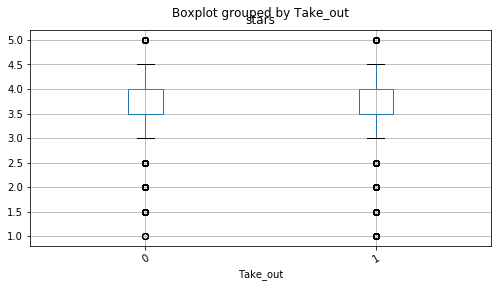

In [52]:
data_n.boxplot('stars','Take_out', rot=30, figsize=(8,4))

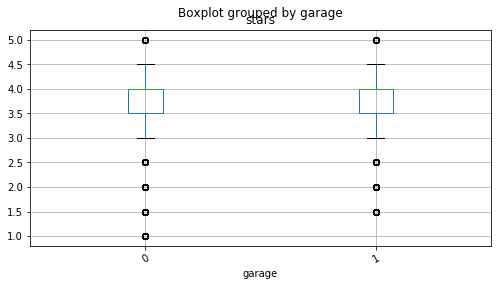

In [53]:
data_n.boxplot('stars','garage', rot=30, figsize=(8,4))

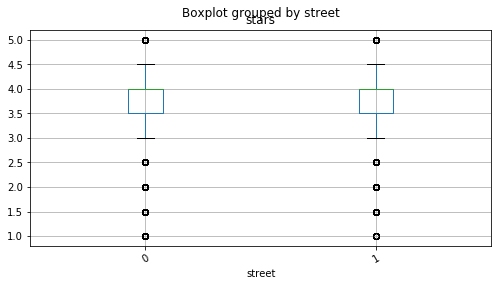

In [54]:
data_n.boxplot('stars','street', rot=30, figsize=(8,4))

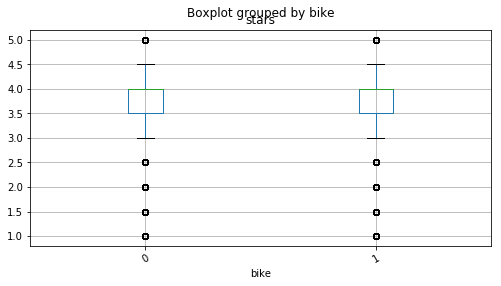

In [55]:
data_n.boxplot('stars','bike', rot=30, figsize=(8,4))

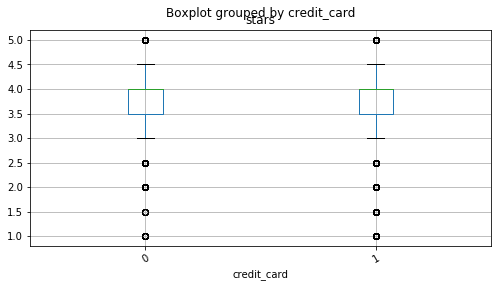

In [56]:
data_n.boxplot('stars','credit_card', rot=30, figsize=(8,4))

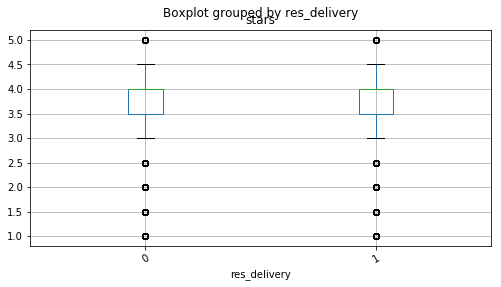

In [57]:
data_n.boxplot('stars','res_delivery', rot=30, figsize=(8,4))

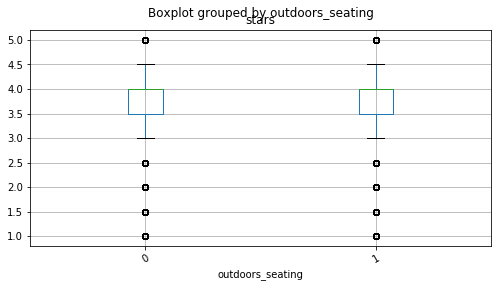

In [58]:
data_n.boxplot('stars','outdoors_seating', rot=30, figsize=(8,4))

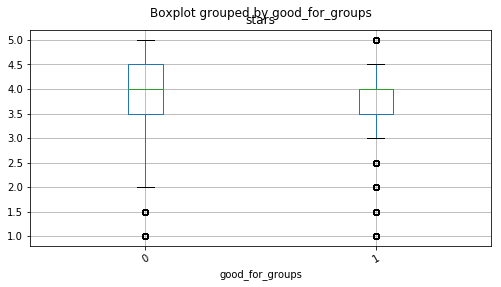

In [59]:
data_n.boxplot('stars','good_for_groups', rot=30, figsize=(8,4))

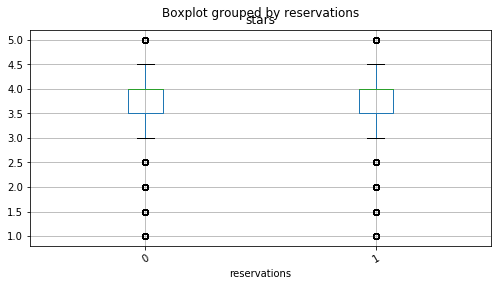

In [60]:
data_n.boxplot('stars','reservations', rot=30, figsize=(8,4))

#### Random sample extracted from the dataset to do the plots:


In [16]:
sample = data.sample(n=1000)
sample.head()

,Unnamed: 0,Business_id,name,city,state,postal_code,stars,categories,Take_out,garage,street,bike,credit_card,good_for_kids,has_tv,noise_level,outdoors_seating,res_attire,res_delivery,good_for_groups,price_range,reservations,Text,Stars,DateR
316685,316685,hU7z5Jtl57RIODS0hPg9Ug,Apache Taco Shop,Las Vegas,NV,89117,4.0,"Food, Restaurants, Breakfast & Brunch, Dessert...",True,False,False,True,True,True,True,quiet,True,casual,True,False,1.0,False,Great food and very nice owners. The fish taco...,5.0,2014-08-20
315661,315661,6YGQcH6v5ndd-Q4ovVRLDQ,Casa Rita's,Matthews,NC,28105,3.5,"Restaurants, Tex-Mex",True,False,False,False,True,True,True,average,False,casual,False,True,2.0,False,I couldn't help but compare Casa Rita's to my ...,2.0,2014-02-24
2619626,2619626,EkYbGk9L5KdCfL3ocZ7ETQ,Vegas Discount Nutrition Superstore,Las Vegas,NV,89123,5.0,"Food, Health & Medical, Health Markets, Specia...",False,False,False,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,Every employee as you walk in the door is help...,5.0,2016-05-31
2298726,2298726,gZ4lKpOxqBEbEQmgpE5JdA,Shades of Beauty,Gilbert,AZ,85295,5.0,"Hair Salons, Beauty & Spas",NaN,NaN,NaN,True,True,True,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,Amy is amazing. She is a hair artist. She ha...,5.0,2018-01-16
1569676,1569676,r8hF3kwnZzxTo1IYNcI6rg,El Sombrero Mexican Bistro,Las Vegas,NV,89101,4.5,"Nightlife, Bars, Mexican, Restaurants",True,False,True,True,True,True,False,average,False,casual,True,True,2.0,True,Very nice! Enjoyed it very much. Ambiance was ...,5.0,2016-03-19


In [17]:
sample.isnull().sum()

Unnamed: 0            0
Business_id           0
name                  0
city                  0
state                 0
postal_code           1
stars                 0
categories            0
Take_out            376
garage              222
street              222
bike                266
credit_card          98
good_for_kids       333
has_tv              390
noise_level         402
outdoors_seating    368
res_attire          424
res_delivery        408
good_for_groups     383
price_range         199
reservations        392
Text                  0
Stars                 0
DateR                 0
dtype: int64

In [18]:
sample=sample.dropna()

In [19]:
sample = pd.DataFrame(sample, columns=['stars','Take_out','garage','street','bike','credit_card','good_for_kids','has_tv','outdoors_seating','res_delivery','good_for_groups','reservations','noise_level','res_attire'])
sample.head()

,stars,Take_out,garage,street,bike,credit_card,good_for_kids,has_tv,outdoors_seating,res_delivery,good_for_groups,reservations,noise_level,res_attire
316685,4.0,True,False,False,True,True,True,True,True,True,False,False,quiet,casual
315661,3.5,True,False,False,False,True,True,True,False,False,True,False,average,casual
1569676,4.5,True,False,True,True,True,True,False,False,True,True,True,average,casual
864062,3.5,True,False,False,True,True,True,True,False,False,True,False,average,casual
3423834,4.5,True,False,False,True,True,True,False,False,False,True,False,average,casual


Text(0.5, 0, 'Noise Level')

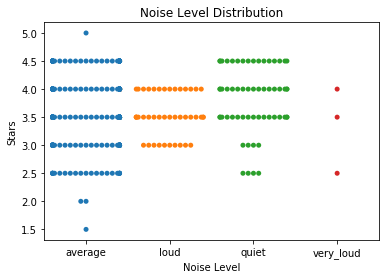

In [65]:
ax=sns.swarmplot(x=sample['noise_level'],y=sample.stars)
ax.set_title('Noise Level Distribution')
ax.set_ylabel('Stars')
ax.set_xlabel('Noise Level')

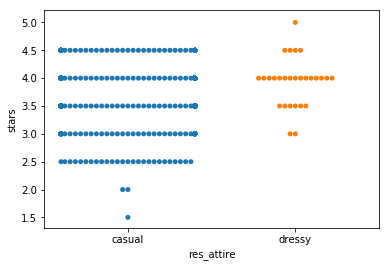

In [66]:
sns.swarmplot(x=sample['res_attire'],y=sample.stars)

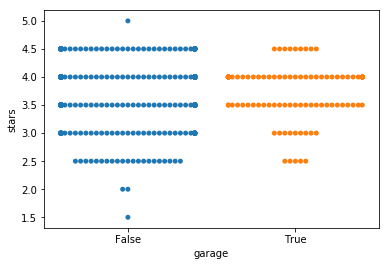

In [67]:
sns.swarmplot(x=sample['garage'],y=sample.stars)

In [68]:
#The swarmplots show the distribution of each categorie in the respective rating.We have taken
#a sample from the data to represent it.

In [20]:
new = pd.DataFrame(data_n,
                   columns=['Take_out', 'garage', 'street', 'bike', 'credit_card', 
                            'good_for_kids', 'has_tv', 'outdoors_seating', 'res_delivery', 
                            'good_for_groups', 'price_range','reservations','stars'])

In [21]:
y = new.pop('stars')
X = new

#### Create 2 masks
-One to filter just the reviews with 5 stars rate.

-The other to filter reviews with 1 star rate, to see in each case which words are more repeated.

In [22]:
data_n[data_n['stars'] == 5.0].shape

(16442, 31)

In [23]:
text_stars5 = data_n[data_n['stars'] == 5.0]

In [24]:
data_n[data_n['stars'] == 1.0].shape

(635, 31)

In [25]:
text_stars1 = data_n[data_n['stars'] == 1.0]

In [26]:
text_fat5 = " ".join(review for review in text_stars5.Text)
print ("There are {} words in the combination of all the reviews.".format(len(text_fat5)))

There are 7548059 words in the combination of all the reviews.


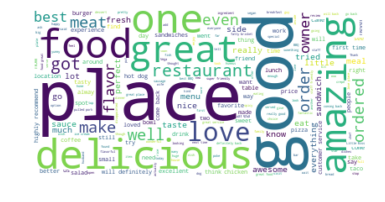

In [80]:
# Create stopword list:
stopwords = set(STOPWORDS)
#stopwords.update(["", "now", "wine", "flavor", "flavors"])

# Generate a word cloud image
wordcloud_fat5 = WordCloud(stopwords=stopwords, background_color="white").generate(text_fat5)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud_fat5, interpolation='bilinear')
plt.axis("off")
plt.show()

In [81]:
text_fat1 = " ".join(review for review in text_stars1.Text)
print ("There are {} words in the combination of all the reviews.".format(len(text_fat1)))

There are 318530 words in the combination of all the reviews.


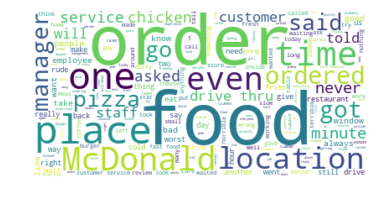

In [82]:
stopwords = set(STOPWORDS)

# Generate a word cloud image
wordcloud_fat1 = WordCloud(stopwords=stopwords, background_color="white").generate(text_fat1)

plt.imshow(wordcloud_fat1, interpolation='bilinear')
plt.axis("off")
plt.show()

### Frequency distribution of features

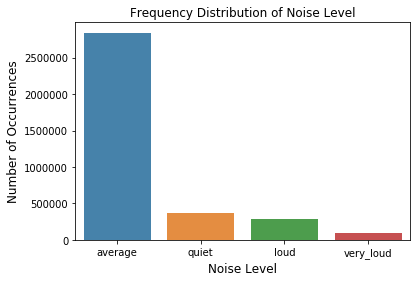

In [83]:
#BAR CHART

noise_level_count = data['noise_level'].value_counts()

sns.barplot(noise_level_count.index, noise_level_count.values, alpha=0.9)
plt.title('Frequency Distribution of Noise Level')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Noise Level', fontsize=12)
plt.show()

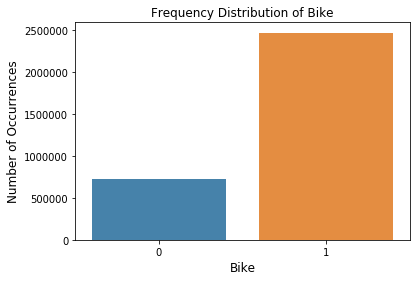

In [84]:
bike_count = data_n['bike'].value_counts()

sns.barplot(bike_count.index, bike_count.values, alpha=0.9)
plt.title('Frequency Distribution of Bike')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Bike', fontsize=12)
plt.show()

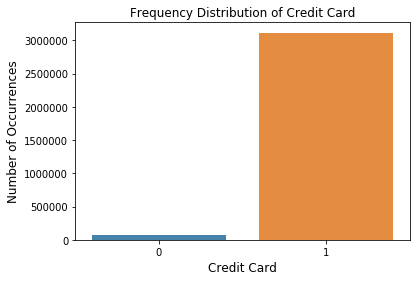

In [85]:
cc_count = data_n['credit_card'].value_counts()

sns.barplot(cc_count.index, cc_count.values, alpha=0.9)
plt.title('Frequency Distribution of Credit Card')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Credit Card', fontsize=12)
plt.show()

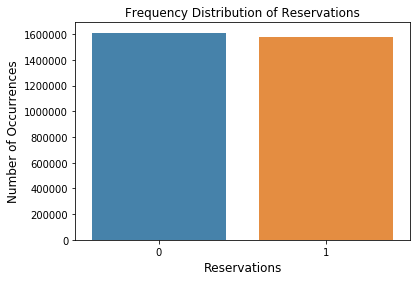

In [86]:
reservation_count = data_n['reservations'].value_counts()

sns.barplot(reservation_count.index, reservation_count.values, alpha=0.9)
plt.title('Frequency Distribution of Reservations')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Reservations', fontsize=12)
plt.show()

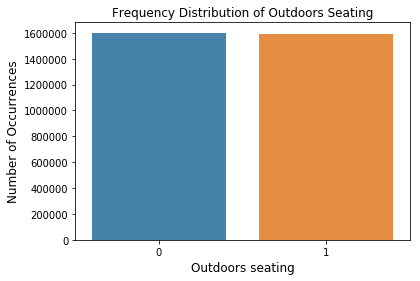

In [87]:
out_count = data_n['outdoors_seating'].value_counts()

sns.barplot(out_count.index, out_count.values, alpha=0.9)
plt.title('Frequency Distribution of Outdoors Seating')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Outdoors seating', fontsize=12)
plt.show()

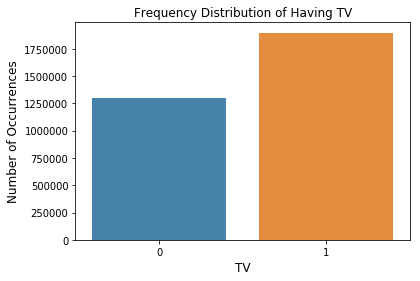

In [88]:
tv_count = data_n['has_tv'].value_counts()

sns.barplot(tv_count.index, tv_count.values, alpha=0.9)
plt.title('Frequency Distribution of Having TV')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('TV', fontsize=12)
plt.show()

In [89]:
noise_level_count

average      2841837
quiet         362508
loud          281692
very_loud      94798
Name: noise_level, dtype: int64

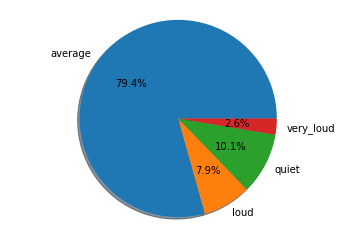

In [90]:
#PIE CHART --> It is the same as bar chart but represented in a different way.

labels = data['noise_level'].astype('category').cat.categories.tolist()
counts = data['noise_level'].value_counts()
sizes = [counts[var_cat] for var_cat in labels]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True) #autopct is show the % on plot
ax1.axis('equal')
plt.show()


#### Convert date column in datatime so python can read that column at what it is:


In [27]:
data_replace = data_n.copy()
data_replace.head(2)

,Unnamed: 0,Business_id,name,city,state,postal_code,stars,categories,Take_out,garage,street,bike,credit_card,good_for_kids,has_tv,...,res_delivery,good_for_groups,reservations,Text,Stars,DateR,noise_level_loud,noise_level_quiet,noise_level_very_loud,res_attire_dressy,res_attire_formal,price_range_2.0,price_range_3.0,price_range_4.0,split_cat
0,0,Apn5Q_b6Nz61Tq4XzPdf9A,Minhas Micro Brewery,Calgary,AB,T2E 6L6,4.0,"Tours, Breweries, Pizza, Restaurants, Food, Ho...",1,0,1,0,1,1,1,...,0,1,1,Great place. Major flaw is how early it closes...,4.0,2014-08-21,0,0,0,0,0,1,0,0,"[Tours, Breweries, Pizza, Restaurants, Foo..."
1,1,Apn5Q_b6Nz61Tq4XzPdf9A,Minhas Micro Brewery,Calgary,AB,T2E 6L6,4.0,"Tours, Breweries, Pizza, Restaurants, Food, Ho...",1,0,1,0,1,1,1,...,0,1,1,The best fresh pizza and selection of micro br...,5.0,2015-06-15,0,0,0,0,0,1,0,0,"[Tours, Breweries, Pizza, Restaurants, Foo..."


In [28]:
data_replace['DateR'].dtype

dtype('O')

In [29]:
data_replace['date_parsed'] = pd.to_datetime(data_replace['DateR'], format='%y/%m/%d', infer_datetime_format=True)

In [30]:
cities = data_replace['city'].unique()
cities.sort()
cities

array(['AGINCOURT', 'Agincourt', 'Ahwatukee', 'Airdrie', 'Ajax',
       'Allison Park', 'Ambridge', 'Amherst', 'Angus', 'Anjou', 'Anthem',
       'Argos', 'Arnold', 'Aspinwall', 'Auburn Township', 'Auburn Twp',
       'Aurora', 'Avalon', 'Avon', 'Avon Lake', 'Avondale', "Baie-D'urfe",
       "Baie-d'Urfé", 'Bainbridge', 'Bainbridge Township', 'Bath',
       'Bay Village', 'Beachwood', 'Beaconsfield', 'Beauharnois',
       'Bedford', 'Bedford Heights', 'Beeton', 'Bellagio', 'Belleville',
       'Bellevue', 'Bellvue', 'Belmont', 'Ben Avon', 'Berea',
       'Bethel Park', 'Black Earth', 'Blainville', 'Blakeney', 'Blawnox',
       'Blue Diamond', 'Boisbriand', 'Bolton', 'Boucherville',
       'Boulder City', 'Braddock', 'Bradford',
       'Bradford West Gwillimbury', 'Brampton', 'Bratenahl',
       'Brecksville', 'Brentwood', 'Bridgeville', 'Broadview Heights',
       'Brook Park', 'Brooklin', 'Brookline', 'Brooklyn', 'Brookpark',
       'Brossard', 'Brunswick', 'Buckeye', 'Burton', 'Caled

In [31]:
data_replace.city.value_counts().count()

536

In [32]:
#Make everything lower case and remove any white spaces at the beginning and end of cells.

data_replace['city'] = data_replace['city'].str.lower()
data_replace['city'] = data_replace['city'].str.strip()


In [33]:
#To help identify which string are closest to each other

from fuzzywuzzy import fuzz
from fuzzywuzzy import process
matches = process.extract('agincourt',cities, limit=10, scorer=fuzz.token_sort_ratio)
matches


/anaconda3/lib/python3.6/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


[('AGINCOURT', 100),
 ('Agincourt', 100),
 ('Anjou', 57),
 ('Canonsburg', 53),
 ('Concord', 50),
 ('Gilbert', 50),
 ('Rantoul', 50),
 ('Windsor', 50),
 ('Bellagio', 47),
 ('Clairton', 47)]

In [34]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
def replace_matches_in_column(df, column, string_to_match, min_ratio=90):
    
    strings = df[column].unique()
    
    for string_to_match in strings:
        matches = process.extract(string_to_match ,strings, limit=10, 
                                  scorer=fuzz.token_sort_ratio)

    close_matches = [matches[0] for matches in matches if matches[1] >= min_ratio]
    
    rows_with_matches = df[column].isin(close_matches)
    
    df.loc[rows_with_matches, column] = string_to_match
    

In [35]:
strings = data_replace['city'].unique()
replace_matches_in_column(df=data_replace, column='city', string_to_match=strings , min_ratio=90)


In [36]:
data_replace.city.value_counts().count()  #Before there were 536, now 524.

524

#### Group by different features and do the mean to see if they are relevant for the ratings.

In [ ]:
city_star_group = data_replace.groupby(['city','stars'])
city_star_group

In [106]:
city_star_group.ngroups

1780

In [107]:
city_star_group.mean().head(10)

Take_out    garage    street      bike  credit_card  \
city      stars                                                        
agincourt 2.0    1.000000  0.000000  0.000000  1.000000          1.0   
          3.0    1.000000  0.000000  0.000000  1.000000          1.0   
ahwatukee 3.0    1.000000  0.000000  0.000000  1.000000          1.0   
          4.0    1.000000  0.000000  0.000000  1.000000          1.0   
airdrie   2.0    1.000000  0.000000  0.000000  1.000000          1.0   
          3.0    0.716418  0.000000  0.000000  1.000000          1.0   
          3.5    0.877049  0.000000  0.245902  0.754098          1.0   
          4.0    0.900000  0.147059  0.423529  1.000000          1.0   
          4.5    1.000000  0.000000  0.627907  1.000000          1.0   
          5.0    1.000000  0.000000  0.125000  1.000000          1.0   

                 good_for_kids    has_tv  outdoors_seating  res_delivery  \
city      stars                                                            
agincourt 2.0         1.000000  1.000000          0.000000      0.000000   
          3.0         1.000000  0.000000          0.000000      0.000000   
ahwatukee 3.0         1.000000  1.000000          0.000000      1.000000   
          4.0         0.698057  1.000000          1.000000      0.000000   
airdrie   2.0         1.000000  1.000000          1.000000      1.000000   
          3.0         1.000000  0.761194          1.000000      0.373134   
          3.5         0.786885  0.352459          0.352459      0.000000   
          4.0         0.900000  0.752941          0.341176      0.488235   
          4.5         1.000000  0.767442          0.000000      0.372093   
          5.0         1.000000  0.750000          0.125000      0.750000   

                 good_for_groups  reservations     Stars  noise_level_loud  \
city      stars                                                              
agincourt 2.0                1.0      0.000000  2.142857          1.000000   
          3.0                1.0      0.000000  2.750000          0.000000   
ahwatukee 3.0                1.0      0.000000  3.117647          0.000000   
          4.0                1.0      0.576981  4.046338          0.000000   
airdrie   2.0                1.0      1.000000  2.100000          0.000000   
          3.0                1.0      0.761194  3.000000          0.238806   
          3.5                1.0      0.721311  3.459016          0.139344   
          4.0                1.0      0.564706  3.929412          0.100000   
          4.5                1.0      0.767442  4.302326          0.000000   
          5.0                1.0      1.000000  4.791667          0.000000   

                 noise_level_quiet  noise_level_very_loud  res_attire_dressy  \
city      stars                                                                
agincourt 2.0             0.000000                    0.0                0.0   
          3.0             0.000000                    1.0                0.0   
ahwatukee 3.0             0.000000                    0.0                0.0   
          4.0             0.000000                    0.0                0.0   
airdrie   2.0             0.000000                    1.0                0.0   
          3.0             0.388060                    0.0                0.0   
          3.5             0.245902                    0.0                0.0   
          4.0             0.252941                    0.0                0.0   
          4.5             0.139535                    0.0                0.0   
          5.0             0.625000                    0.0                0.0   

                 res_attire_formal  price_range_2.0  price_range_3.0  \
city      stars                                                        
agincourt 2.0                  0.0         0.000000              0.0   
          3.0                  0.0         0.000000              0.0   
ahwatukee 3.0                  0.0         0.000000  

In [108]:
city_group = data_replace.groupby('city')

In [109]:
average_stars_per_city = city_group.mean()
average_stars_per_city

,stars,Take_out,garage,street,bike,credit_card,good_for_kids,has_tv,outdoors_seating,res_delivery,good_for_groups,reservations,Stars,noise_level_loud,noise_level_quiet,noise_level_very_loud,res_attire_dressy,res_attire_formal,price_range_2.0,price_range_3.0,price_range_4.0
city,,,,,,,,,,,,,,,,,,,,,
agincourt,2.363636,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.636364,0.000000,0.000000,1.000000,0.000000,2.363636,0.636364,0.000000,0.363636,0.000000,0.000000,0.000000,0.000000,0.000000
ahwatukee,3.887268,1.000000,0.000000,0.000000,1.000000,1.000000,0.732095,1.000000,0.887268,0.112732,1.000000,0.511936,3.941645,0.000000,0.000000,0.000000,0.000000,0.000000,0.511936,0.000000,0.000000
airdrie,3.790426,0.891489,0.053191,0.287234,0.936170,1.000000,0.908511,0.661702,0.412766,0.382979,1.000000,0.714894,3.719149,0.106383,0.287234,0.042553,0.000000,0.000000,0.891489,0.000000,0.000000
ajax,3.729657,0.992603,0.000000,0.068594,0.641560,0.982515,0.955615,0.592468,0.258911,0.381305,0.893746,0.669805,3.712172,0.053800,0.188299,0.000000,0.021520,0.000000,0.761937,0.040350,0.000000
allison park,3.817829,1.000000,0.000000,0.000000,0.627907,1.000000,0.788760,0.837209,0.542636,0.102713,1.000000,0.496124,3.835271,0.025194,0.160853,0.000000,0.000000,0.000000,0.821705,0.089147,0.000000
ambridge,4.092282,1.000000,0.000000,0.674497,0.828859,0.805369,0.694631,0.614094,0.010067,0.100671,0.969799,0.197987,4.197987,0.000000,0.305369,0.000000,0.000000,0.000000,0.332215,0.000000,0.000000
amherst,3.668353,0.943642,0.000000,0.263006,0.729769,1.000000,0.958092,0.601156,0.543353,0.043353,1.000000,0.384393,3.628613,0.056358,0.117052,0.000000,0.000000,0.000000,0.523121,0.000000,0.000000
angus,4.022727,1.000000,0.000000,0.136364,0.590909,0.727273,0.727273,0.727273,0.000000,0.318182,0.863636,0.590909,4.090909,0.272727,0.272727,0.000000,0.000000,0.000000,0.727273,0.000000,0.000000
anjou,3.128571,0.585714,0.000000,0.000000,0.528571,1.000000,0.757143,0.942857,0.771429,0.100000,1.000000,1.000000,3.100000,0.285714,0.000000,0.485714,0.057143,0.000000,0.285714,0.714286,0.000000


In [110]:
#The top best cities rated:
average_stars_per_city.sort_values(by='stars', ascending=False).head(5)

,stars,Take_out,garage,street,bike,credit_card,good_for_kids,has_tv,outdoors_seating,res_delivery,good_for_groups,reservations,Stars,noise_level_loud,noise_level_quiet,noise_level_very_loud,res_attire_dressy,res_attire_formal,price_range_2.0,price_range_3.0,price_range_4.0
city,,,,,,,,,,,,,,,,,,,,,
rillton,5.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,4.857143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
rural ridge,5.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,4.750000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
topaz,5.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,4.809524,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
west elizabeth,5.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,4.750000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ranlo,4.5,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,4.571429,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [111]:
#The 5 worst rated cities:
average_stars_per_city.sort_values(by='stars', ascending=False).tail(5)

,stars,Take_out,garage,street,bike,credit_card,good_for_kids,has_tv,outdoors_seating,res_delivery,good_for_groups,reservations,Stars,noise_level_loud,noise_level_quiet,noise_level_very_loud,res_attire_dressy,res_attire_formal,price_range_2.0,price_range_3.0,price_range_4.0
city,,,,,,,,,,,,,,,,,,,,,
n las vegas,2.333333,1.0,0.0,0.000000,1.000000,1.0,1.0,0.000000,0.666667,0.000000,1.000000,0.000000,2.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
munhall,2.153153,1.0,0.0,0.081081,0.153153,1.0,1.0,0.081081,0.000000,0.081081,0.927928,0.081081,2.099099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
oakwood village,2.000000,1.0,0.0,0.000000,1.000000,1.0,1.0,1.000000,0.000000,0.000000,1.000000,0.000000,1.857143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
blawnox,2.000000,1.0,0.0,0.000000,1.000000,1.0,1.0,1.000000,0.000000,1.000000,1.000000,1.000000,2.142857,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
ft. mill,2.000000,1.0,0.0,1.000000,1.000000,1.0,1.0,1.000000,1.000000,0.000000,1.000000,0.000000,2.246377,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [112]:
data_replace.credit_card.mean()

0.9756341572704395

In [113]:
data_replace.credit_card.value_counts()

1    3115755
0      77814
Name: credit_card, dtype: int64

In [114]:
data_replace.bike.value_counts(normalize=True)

1    0.772375
0    0.227625
Name: bike, dtype: float64

### Is there class imbalance?

Text(0.5, 1.0, 'Star Rating Distribution')

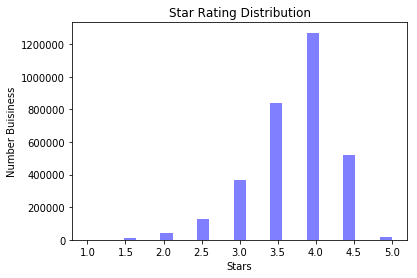

In [37]:
ax = data_replace.stars.hist(grid=False, bins=25, color='b', alpha=0.5)
ax.set_xlabel("Stars")
ax.set_ylabel("Number Buisiness")
ax.set_title("Star Rating Distribution")
#We just discovered that exists a class imbalance between different rating classes, so we will
#take it into account when doing the modeling in further steps.(little bit skewed)

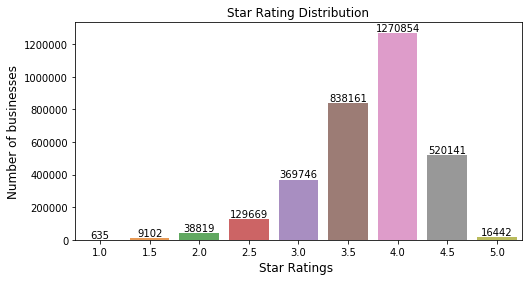

In [116]:
#Distribution of the ratings
x=data_replace['stars'].value_counts()
x=x.sort_index()

#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Star Rating Distribution")
plt.ylabel('Number of businesses', fontsize=12)
plt.xlabel('Star Ratings ', fontsize=12)

#adding text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [117]:
data_replace.stars.value_counts(normalize=True)

4.0    0.397942
3.5    0.262453
4.5    0.162871
3.0    0.115778
2.5    0.040603
2.0    0.012155
5.0    0.005148
1.5    0.002850
1.0    0.000199
Name: stars, dtype: float64

In [118]:
bike_group = data_replace.groupby(['bike'])
bike_group.mean()

,stars,Take_out,garage,street,credit_card,good_for_kids,has_tv,outdoors_seating,res_delivery,good_for_groups,reservations,Stars,noise_level_loud,noise_level_quiet,noise_level_very_loud,res_attire_dressy,res_attire_formal,price_range_2.0,price_range_3.0,price_range_4.0
bike,,,,,,,,,,,,,,,,,,,,
0,3.664080,0.757342,0.440276,0.081974,0.979781,0.699063,0.538271,0.281309,0.100712,0.932159,0.567323,3.661177,0.078305,0.094640,0.017028,0.138433,0.000475,0.554994,0.195233,0.071328
1,3.770974,0.951726,0.081450,0.305639,0.974412,0.821927,0.610197,0.562880,0.193421,0.941062,0.474162,3.768054,0.068816,0.094781,0.010677,0.021670,0.000073,0.682831,0.046705,0.004745


In [119]:
cc_group = data_replace.groupby('credit_card')
cc_group.mean()

,stars,Take_out,garage,street,bike,good_for_kids,has_tv,outdoors_seating,res_delivery,good_for_groups,reservations,Stars,noise_level_loud,noise_level_quiet,noise_level_very_loud,res_attire_dressy,res_attire_formal,price_range_2.0,price_range_3.0,price_range_4.0
credit_card,,,,,,,,,,,,,,,,,,,,
0,3.838223,0.916056,0.036227,0.542949,0.811114,0.888812,0.285103,0.266225,0.072339,0.714486,0.153032,3.836071,0.130362,0.108053,0.007608,0.000617,0.000103,0.398232,0.020125,0.001118
1,3.744355,0.907265,0.166297,0.247529,0.771407,0.791591,0.601535,0.504595,0.174815,0.944644,0.503918,3.741420,0.069493,0.094417,0.012235,0.049438,0.000166,0.660113,0.082022,0.020370


In [120]:
tv_group = data_replace.groupby('has_tv')
tv_group.mean()

,stars,Take_out,garage,street,bike,credit_card,good_for_kids,outdoors_seating,res_delivery,good_for_groups,reservations,Stars,noise_level_loud,noise_level_quiet,noise_level_very_loud,res_attire_dressy,res_attire_formal,price_range_2.0,price_range_3.0,price_range_4.0
has_tv,,,,,,,,,,,,,,,,,,,,
0,3.770949,0.845789,0.154478,0.304216,0.741242,0.957114,0.804978,0.422072,0.147620,0.893000,0.398744,3.768887,0.059147,0.129711,0.010701,0.065827,0.000318,0.525553,0.115577,0.031871
1,3.730017,0.949676,0.169044,0.220877,0.793670,0.988302,0.786424,0.551260,0.189212,0.970524,0.561458,3.726516,0.079066,0.070835,0.013094,0.036225,0.000059,0.741406,0.056530,0.011713


In [121]:
out_group = data_replace.groupby('outdoors_seating')
out_group.mean()

,stars,Take_out,garage,street,bike,credit_card,good_for_kids,has_tv,res_delivery,good_for_groups,reservations,Stars,noise_level_loud,noise_level_quiet,noise_level_very_loud,res_attire_dressy,res_attire_formal,price_range_2.0,price_range_3.0,price_range_4.0
outdoors_seating,,,,,,,,,,,,,,,,,,,,
0,3.724428,0.875176,0.178766,0.206821,0.673607,0.964328,0.827859,0.531656,0.182666,0.920714,0.466283,3.722765,0.068376,0.127203,0.011014,0.054763,0.000269,0.600012,0.090480,0.029746
1,3.768964,0.939941,0.147413,0.302866,0.871622,0.986995,0.759897,0.656296,0.161921,0.957446,0.524594,3.764788,0.073588,0.062138,0.013236,0.041702,0.000059,0.707714,0.070499,0.010007


In [122]:
reservations_group = data_replace.groupby('reservations')
reservations_group.mean()

,stars,Take_out,garage,street,bike,credit_card,good_for_kids,has_tv,outdoors_seating,res_delivery,good_for_groups,Stars,noise_level_loud,noise_level_quiet,noise_level_very_loud,res_attire_dressy,res_attire_formal,price_range_2.0,price_range_3.0,price_range_4.0
reservations,,,,,,,,,,,,,,,,,,,,
0,3.736022,0.949387,0.117451,0.229838,0.804832,0.959105,0.910007,0.516053,0.469899,0.167147,0.896052,3.731064,0.075907,0.093794,0.009596,0.000949,0.000128,0.540735,0.018388,0.000346
1,3.757461,0.864789,0.209658,0.280082,0.739311,0.992473,0.675744,0.673051,0.528215,0.177586,0.982824,3.756625,0.065952,0.095722,0.014696,0.096432,0.000201,0.768843,0.143801,0.039821


In [123]:
city_kids_group = data_replace.groupby(['city','good_for_kids'])
city_kids_group.mean().head()

stars  Take_out    garage    street      bike  \
city      good_for_kids                                                     
agincourt 1              2.363636  1.000000  0.000000  0.000000  1.000000   
ahwatukee 0              4.000000  1.000000  0.000000  0.000000  1.000000   
          1              3.846014  1.000000  0.000000  0.000000  1.000000   
airdrie   0              3.697674  0.604651  0.000000  0.000000  1.000000   
          1              3.799766  0.920375  0.058548  0.316159  0.929742   

                         credit_card    has_tv  outdoors_seating  \
city      good_for_kids                                            
agincourt 1                      1.0  0.636364          0.000000   
ahwatukee 0                      1.0  1.000000          1.000000   
          1                      1.0  1.000000          0.846014   
airdrie   0                      1.0  1.000000          1.000000   
          1                      1.0  0.627635          0.353630   

                         res_delivery  good_for_groups  reservations  \
city      good_for_kids                                                
agincourt 1                  0.000000              1.0      0.000000   
ahwatukee 0                  0.000000              1.0      1.000000   
          1                  0.153986              1.0      0.333333   
airdrie   0                  0.000000              1.0      0.604651   
          1                  0.421546              1.0      0.725995   

                            Stars  noise_level_loud  noise_level_quiet  \
city      good_for_kids                                                  
agincourt 1              2.363636          0.636364           0.000000   
ahwatukee 0              4.222772          0.000000           0.000000   
          1              3.838768          0.000000           0.000000   
airdrie   0              3.511628          0.395349           0.000000   
          1              3.740047          0.077283           0.316159   

                         noise_level_very_loud  res_attire_dressy  \
city      good_for_kids                                             
agincourt 1                           0.363636                0.0   
ahwatukee 0                           0.000000                0.0   
          1                           0.000000                0.0   
airdrie   0                           0.000000                0.0   
          1                           0.046838                0.0   

                         res_attire_formal  price_range_2.0  price_range_3.0  \
city      good_for_kids                                                        
agincourt 1                            0.0         0.000000              0.0   
ahwatukee 0                            0.0         1.000000              0.0   
          1                            0.0         0.333333              0.0   
airdrie   0                            0.0         1.000000              0.0   
          1                            0.0         0.880562              0.0   

                         price_range_4.0  
city      good_for_kids                   
agincourt 1                          0.0  
ahwatukee 0                          0.0  
          1                          0.0  
airdrie   0                          0.0  
          1                          0.0

# 3rd --> NLP

In [38]:
file1 = pd.read_csv('test.csv', low_memory=False)

In [39]:
file1.rename(columns={'stars':'Rating'}, inplace=True)

- To reduce the amount of features I had I set the parameter max_features=2000 to take into consideration just the words (features) that appear more frequently in the reviews. First I try to clean the initially 65707 features with conditions such as deleting features that were containing digits or that appear just once, but it wasn't enough and the remaining amount of words was too high. Due to the time it was taken me filtering by these conditions and the problems of joining this dataframe with the original one (that was killing the kernel continuosly) I decided to reduce drastically the amount of features to 2000.

In [40]:
# Setting the vectorizer just like we would set a model
cvec = CountVectorizer(stop_words='english', strip_accents ='unicode', max_features=2000)
    
# Fitting the vectorizer on our training data
cvec.fit(file1['text'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=2000, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents='unicode', token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [41]:
words = cvec.get_feature_names()
print(words[1000:1020])
print()
# number of different words
print(len(words))

['longer', 'look', 'looked', 'looking', 'looks', 'lost', 'lot', 'lots', 'loud', 'lounge', 'love', 'loved', 'lovely', 'lover', 'loves', 'low', 'lower', 'luckily', 'lucky', 'lunch']

2000


In [42]:
cvec_mat = cvec.transform(file1['text'])

In [43]:
cvec_mat.shape

(14473, 2000)

In [44]:
a = cvec_mat.sum(axis=0)
words_sum = pd.DataFrame(a,columns=words).transpose().sort_values(by=0,ascending=False)
words_sum.head()

,0
food,11394
good,8995
place,8185
great,7105
service,6084


#### DataFrame with the word features

In [45]:
words_features = pd.DataFrame(cvec_mat.toarray(), columns=list(cvec.get_feature_names()))
words_features.head()

,00,10,100,11,12,13,14,15,16,17,18,1st,20,22,24,...,written,wrong,yeah,year,years,yellow,yelp,yes,yesterday,york,young,yuck,yum,yummy,zero
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [46]:
words_features.shape

(14473, 2000)

### Concatenate original dataframe with word features

In [47]:
pd.set_option('display.max_columns', 2469)
result = pd.concat([words_features, file1], sort=True, axis=1)
result.head(2)

,00,10,100,11,12,13,14,15,16,17,18,1st,20,22,24,25,2nd,30,32,35,40,45,50,60,75,90,95,99,able,absolute,absolutely,accommodate,accommodating,actual,actually,add,added,adding,addition,additional,adds,admit,adult,affordable,afternoon,ago,agree,agreed,ahead,air,airport,al,alcohol,alfredo,allow,allowed,almond,alright,amazing,ambiance,ambience,american,anniversary,annoyed,annoying,answer,answered,anymore,anytime,anyways,apart,apologize,apologized,apology,app,apparently,appeared,appetizer,appetizers,apple,appreciate,appreciated,apps,area,aren,arizona,arrive,arrived,art,arugula,asada,asian,aside,ask,asked,asking,asparagus,assume,ate,atmosphere,attention,attentive,attitude,au,authentic,available,average,avocado,avoid,away,awesome,awful,awhile,awkward,az,baby,background,bacon,bad,bag,bagel,baked,bakery,baklava,balance,banana,bananas,band,bar,barely,bars,bartender,bartenders,base,based,basic,basically,basil,basket,bass,bathroom,bathrooms,batter,battered,bbq,bean,beans,beat,beautiful,beautifully,bed,beef,beer,beers,began,begin,beginning,believe,bell,bella,belly,bento,best,bet,better,beverage,beverages,bf,big,bigger,biggest,birthday,biscuit,biscuits,bisque,bit,bite,bites,black,bland,bloody,blown,blue,board,boba,bocata,bomb,bone,boneless,bonus,book,booth,booths,border,boring,bother,bottle,bottles,bought,bowl,bowls,box,boy,boyfriend,boys,bread,breading,break,breakfast,brick,bright,bring,bringing,brings,brisket,broccoli,broken,broth,brother,brought,brown,browns,brulee,brunch,brutta,bucks,buffalo,buffet,building,bulgarian,bun,bunch,buns,burger,burgers,burnt,burrito,burritos,business,busy,butter,buttery,buy,bww,ca,cabbage,caesar,cafe,cajun,cake,cakes,calamari,california,called,calling,came,canned,car,card,care,careful,carne,carnitas,carrot,carrots,carry,case,cash,cashier,casino,casual,catch,caught,cause,cave,celebrate,center,certain,certainly,cesar,chain,chairs,chance,change,changed,changes,charge,charged,charlotte,charm,charming,chat,cheap,cheaper,check,checked,checking,cheddar,cheese,cheesecake,cheesesteak,cheesy,chef,chefs,chewy,chicago,chicken,children,chile,chili,chill,chinese,chip,chipotle,chips,chirashi,chocolate,choice,choices,choose,chop,chopped,chops,chorizo,chose,chow,chowder,christmas,chunks,cilantro,cinebarre,cinnamon,city,clam,clams,class,classic,classy,clay,clean,cleaned,clear,clearly,cleveland,close,closed,closer,closing,club,cocktail,cocktails,coconut,coffee,coke,cold,coleslaw,college,com,combination,combo,come,comes,comfort,comfortable,coming,comment,community,company,compare,compared,complain,complained,complaint,complaints,complete,completely,complimentary,concept,confit,confused,consider,considering,consistency,consistent,consistently,constantly,contact,continue,convenient,conversation,cook,cooked,cookie,cookies,cooking,cooks,cool,corn,corner,correct,cost,couldn,counter,country,couple,coupon,course,courteous,cover,covered,cow,cozy,crab,craft,crap,crappy,craving,crazy,cream,creamed,creamy,creative,credit,creek,creme,crisp,crispy,cristo,crowd,crowded,crunchy,crust,cuisine,cup,cups,curds,curry,customer,customers,cut,cute,dad,daily,damn,dark,darn,date,dates,daughter,day,days,dead,deal,decent,decide,decided,decision,decor,decorated,deep,def,definitely,delicious,delightful,delish,deliver,delivered,delivery,denny,depending,desert,desired,despite,dessert,desserts,devil,did,didn,didnt,die,diet,difference,different,difficult,dim,dine,dined,diner,diners,dining,dinner,dinners,dip,dipping,dirty,disappoint,disappointed,disappointing,disappointment,discount,discovered,disgusting,dish,dishes,display,distance,dive,does,doesn,dog,dogs,doing,dollar,dollars,don,dont,donut,donuts,door,doors,double,doubt,dough,downside,downtown,dozen,draft,dragon,dressed,dressing,dried,drink,drinking,drinks,drive,driving,drop,dropped,drove,drunk,dry,duck,ducks,dumplings,earlier,early,easily,east,eastern,easy,eat,eaten,eater,eating,eats,eddie,edible,eel,efficient,effort,egg,eggplant,eggs,el,employee,employees,en,encanto,enchilada,enchiladas,end,ended,english,enjoy

In [48]:
result.shape

(14473, 2467)

### Solving class imbalance problem

In [49]:
result.drop(columns=['business_id','dater','split_cat','categories','postal_code','state','name','city','date_parsed','text'],inplace=True)


### Target and predictors


In [50]:
#Z=result.pop('text')
y= result.pop('Rating')
X= result


### UNDERSAMPLING

In [51]:
sampler = RandomOverSampler(random_state=1)
X_resampled, y_resampled = sampler.fit_sample(X, y)
print(pd.Series(y_resampled).value_counts())

/anaconda3/lib/python3.6/site-packages/imblearn/utils/_validation.py:93: UserWarning: 'y' should be of types ('binary', 'multiclass', 'multilabel-indicator') only. Got continuous instead.
  TARGET_KIND, type_of_target(y)))


3.5    5762
1.5    5762
5.0    5762
3.0    5762
2.5    5762
4.5    5762
2.0    5762
1.0    5762
4.0    5762
dtype: int64


In [52]:
#Create train/test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, #stratify=y, 
                                                    random_state=1)

# MODELING - Regression

- Linear Regression + GS

In [53]:
lr = LinearRegression()

# get cross validated scores
scores = cross_val_score(lr, X_train, y_train, cv=4)
print("CV training scores:", scores)
print("Mean CV training score:", scores.mean())
# fit and evaluate the data on the whole training set
lr.fit(X_train, y_train)
print("Training Score:", lr.score(X_train, y_train))
# evaluate the data on the test set
print("Test Score:", lr.score(X_test, y_test))

CV training scores: [0.97991278 0.97947855 0.97755399 0.97892315]
Mean CV training score: 0.9789671200786838
Training Score: 0.9835876750060888
Test Score: 0.9793248524472598


In [54]:
preds_lr = lr.predict(X_test)
np.sqrt(mean_squared_error(y_test, preds_lr))

0.18598589079866473

In [55]:
lr.coef_

array([-0.00488419, -0.04338011, -0.06861575, ...,  0.        ,
        0.        ,  0.        ])

In [56]:
parameters = {'fit_intercept':[True,False], 
              'normalize':[True,False], 
              'copy_X':[True, False]}

gs_reg = GridSearchCV(lr, parameters, cv=2, n_jobs=-1, )
gs_reg.fit(X_train, y_train)

print(gs_reg.best_score_)
print(gs_reg.score(X_train,y_train))
print(gs_reg.score(X_test,y_test))

preds_gsreg = gs_reg.predict(X_test)
print('MSE: ', mean_squared_error(y_test, preds_gsreg))



0.9767161600305792
0.9835876750060888
0.9793248524472598
MSE:  0.03459075157617284


In [57]:
pre = pd.DataFrame({"Predictions" : preds_lr,
             "Actual" : y_test})
pre.head()

,Predictions,Actual
0,4.997293,5.0
1,1.506640,1.5
2,1.508907,1.5
3,4.285170,4.5
4,3.322043,3.0


In [58]:
np.sqrt(mean_squared_error(y_test, preds_lr))

0.18598589079866473

- Ridge

In [59]:
ridge_b = RidgeCV(alphas=np.logspace(0,5,200),cv=2)
optimal_ridge= ridge_b.fit(X_train,y_train).alpha_
optimal_ridge

ridge_cv=Ridge(alpha=optimal_ridge)      

ridge_scores = cross_val_score(ridge_cv, X_train, y_train, cv=3)

print(ridge_scores)
print(np.mean(ridge_scores))

ridge_cv.fit(X_train, y_train)
print(ridge_cv.score(X_test,y_test))

pred_ridge = ridge_b.predict(X_test)
print(mean_squared_error(y_test, pred_ridge))

[0.97962172 0.97810123 0.97787148]
0.9785314768962486
0.9792548741801564
0.03470782937921744


- Decision Tree Regressor + GS

In [60]:
regressor = DecisionTreeRegressor(criterion='mse',
                                  max_depth=None)
regressor.fit(X_train, y_train)

print(cross_val_score(regressor, X_train, y_train, cv=5).mean()) 
print(regressor.score(X_train, y_train))
print(regressor.score(X_test, y_test))
preds_reg = regressor.predict(X_test)
print('MSE: ', mean_squared_error(y_test, preds_reg))

feature_importances = regressor.feature_importances_
importances = pd.DataFrame(list(zip(result.columns,regressor.feature_importances_)),columns=['Feature','Importance']).sort_values(by='Importance',ascending=False)
importances.set_index('Feature', inplace=True)
print(importances.head(10))




0.9994350504139111
1.0
0.9995389838938554
MSE:  0.0007713073659853452
               Importance
Feature                  
price_range      0.573905
delis            0.087428
sandwiches       0.053314
cafes            0.049185
bike             0.027444
pizza            0.024524
tacos            0.023238
good_for_kids    0.020841
fast_food        0.017934
mexican          0.017033


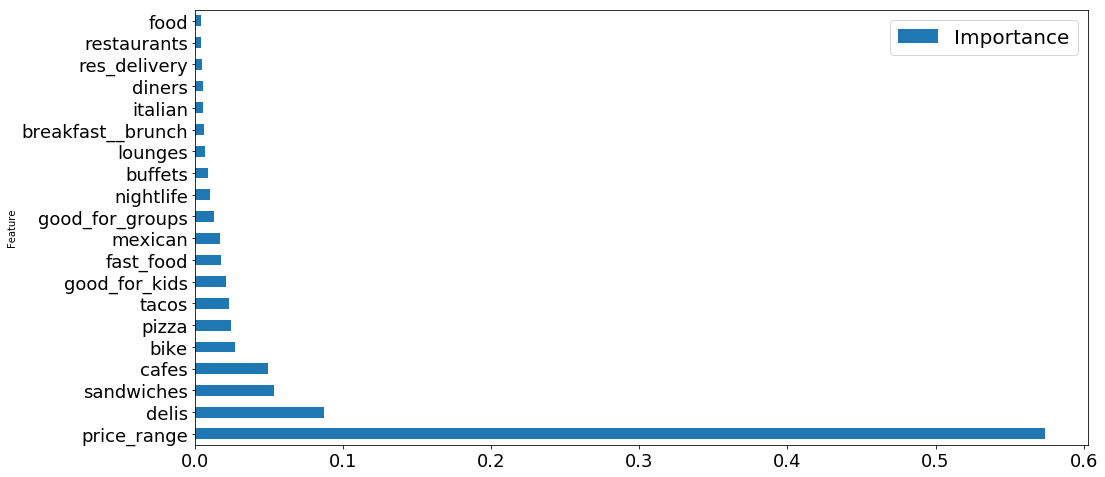

In [61]:
#to plot feature importances:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 8))
importances[:20].plot(kind='barh', ax=ax, fontsize=18, use_index=True)
plt.legend(fontsize=20)
plt.show()



In [62]:
# Gridsearch with Decision Trees to choose the greatest parameters and improve the score
dtr_params = {
    'max_depth':[1,2,3, None],
    'max_features':[None,20,50,100],
    'min_samples_split':[2,5,10]
}

dtr_gs = GridSearchCV(regressor, dtr_params, cv=3, verbose=1, n_jobs=-1)

dtr_gs.fit(X_train, y_train)
dtr_best = dtr_gs.best_estimator_
print(dtr_gs.best_params_)
print(dtr_gs.best_score_)

dtr_best = dtr_gs.best_estimator_
dtr_best

dtr_best.score(X_test,y_test)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  6.9min finished


{'max_depth': None, 'max_features': None, 'min_samples_split': 2}
0.9993676502046746


0.9995677974004894

- Bagging

In [63]:
breg = BaggingRegressor(base_estimator= regressor,
                                max_features= 1.0,
                                bootstrap_features=False,
                                random_state=1)
breg.fit(X_train, y_train)

print(breg.score(X_test, y_test))
print(breg.score(X_train, y_train))

pred_bag= breg.predict(X_test)
print(mean_squared_error(y_test, pred_bag))



0.9994887043247789
0.9999170460797563
0.0008554280755881219


# MODELING - Classification


#### First change the target column to object instead of float

In [66]:
y_resampled.dtype

dtype('float64')

In [71]:
data.stars.head()

0    4.0
1    4.0
2    4.0
3    4.0
4    4.0
Name: stars, dtype: float64

In [74]:
y_resampled = y_resampled.astype(str)
y_resampled

print(y_resampled.dtype)

data['stars'] = data['stars'].astype(str)
data['stars'].head(5)

<U32


0    4.0
1    4.0
2    4.0
3    4.0
4    4.0
Name: stars, dtype: object

#### Apply models

In [75]:
#target and features
y_cat = y_resampled
X = result

#train-test split
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_resampled,y_cat, 
                                                    test_size=0.3,random_state=1)

- LOGISTIC REGRESSION

In [76]:
logr = LogisticRegression(multi_class='auto')
logr.fit(X_train_c, y_train_c)

print(logr.score(X_train_c,y_train_c))
print(logr.score(X_test_c,y_test_c))

preds_clas = logr.predict(X_train_c)

pre_c = pd.DataFrame({"Predictions" : preds_clas,
             "Actual" : y_train_c})
pre_c.head()


print(mean_squared_error(y_train_c.astype(np.float64), preds_clas.astype(np.float64)))

list(logr.get_params().keys())

#GRID SEARCH
params = {'C':np.logspace(-5,5,15),
          'penalty':['l1','l2'],
          'fit_intercept':[True,False]}

gs = GridSearchCV(estimator=logr,
                  param_grid=params,
                  cv=2,
                  scoring='accuracy',
                  return_train_score=True,verbose=1, n_jobs=-1)

gs.fit(X_train_c,y_train_c)

print('Best estimator', gs.best_estimator_)
print('Best score', gs.best_score_)
print('Best parameters', gs.best_params_)

gslog_best = gs.best_estimator_
print(gslog_best.score(X_test_c,y_test_c))

pred_test_clas = logr.predict(X_test_c)

print(mean_squared_error(y_test_c.astype(np.float64), pred_test_clas.astype(np.float64)))

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9960330578512396
0.9838668209281398
0.0017561983471074381
Fitting 2 folds for each of 60 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  7.9min finished
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Best estimator LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
Best score 0.9851790633608816
Best parameters {'C': 1.0, 'fit_intercept': True, 'penalty': 'l1'}
0.9911942409050006
0.008596863350044993


EVALUATING CLASSIFIER

In [83]:
pred_cat = logr.predict(X_test_c)
logr.score(X_test_c,y_test_c) 


# returns an array with three columns indicating being or not being in class 1, 2, 3, 4 or 5
y_bin = label_binarize(y_train_c, logr.classes_)
y_bin[:10]

logr.classes_

print('ACCURACY SCORE')
print(metrics.accuracy_score(y_test_c, pred_cat))
print('')
print('CONFUSION MATRIX')
print(pd.DataFrame(confusion_matrix(y_test_c,pred_cat)))
print('')
print('CLASSIFICATION REPORT')
print(classification_report(y_test_c,pred_cat))


ACCURACY SCORE
0.9838668209281398

CONFUSION MATRIX
      0     1     2     3     4     5     6     7     8
0  1755     0     0     0     0     0     0     0     0
1     0  1680     0     0     0     0     0     0     0
2     0     0  1694     0     0     0     0     0     0
3     0     0     0  1685     0     0     0     0     0
4     0     0     0     0  1730    13     6     2     0
5     0     1     0    20    49  1634    30    10     0
6     0     0     0    11    19    77  1618    11     0
7     0     0     0     0     0     0     2  1716     0
8     0     0     0     0     0     0     0     0  1795

CLASSIFICATION REPORT
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00      1755
         1.5       1.00      1.00      1.00      1680
         2.0       1.00      1.00      1.00      1694
         2.5       0.98      1.00      0.99      1685
         3.0       0.96      0.99      0.97      1751
         3.5       0.95      0.94      0

#### DECISION TREES - Classifier

In [86]:
from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier(max_depth=None)
classifier.fit(X_train_c, y_train_c)
print(classifier.score(X_train_c, y_train_c))
print(cross_val_score(classifier, X_train_c, y_train_c, cv=3).mean()) 
print(classifier.score(X_test_c, y_test_c))


#GRID SEARCH
dtc_params = {
    'max_depth':[None, 5,10,20],
    'max_features':[None,500,2000],
    'min_samples_split':[10,15,20]
}
dtc_gs = GridSearchCV(classifier, dtc_params, cv=3, verbose=1, n_jobs=-1)

dtc_gs.fit(X_train_c, y_train_c)
dtc_best = dtc_gs.best_estimator_
print(dtc_gs.best_params_)
print(dtc_gs.best_score_)

print(dtc_best.score(X_train_c, y_train_c))

print(dtc_best.score(X_test_c, y_test_c))

pred_dtc= dtc_gs.predict(X_test_c)
print(mean_squared_error(y_test_c.astype(np.float64), pred_dtc.astype(np.float64)))

print(metrics.accuracy_score(y_test_c, pred_dtc))

feature_importances = classifier.feature_importances_
importances = pd.DataFrame(list(zip(result.columns,classifier.feature_importances_)),columns=['Feature','Importance']).sort_values(by='Importance',ascending=False)
importances.set_index('Feature', inplace=True)
importances.head(10)

1.0
0.9973552807841948
0.9976218022882118
Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  9.3min finished


{'max_depth': None, 'max_features': 2000, 'min_samples_split': 15}
0.9977961432506887
0.999366391184573
0.9969147705360586
0.003294125208895745
0.9969147705360586


,Importance
Feature,
price_range,0.140378
delis,0.117823
bagels,0.090810
pizza,0.061017
outdoors_seating,0.050664
breakfast__brunch,0.030460
sandwiches,0.030170
has_tv,0.029346
street,0.029109


#### BAGGING - Classifier

In [87]:
bagging_c = BaggingClassifier(base_estimator=classifier,
                            max_samples=0.8, max_features=0.8, n_estimators=100)

print("DT Bagging CV training score:\t", cross_val_score(bagging_c, X_train_c, y_train_c,
                                                         cv=5, n_jobs=-1).mean())
bagging_c.fit(X_train_c, y_train_c)
print("DT bagging test score:\t", bagging_c.score(X_test_c, y_test_c))

print(bagging_c.score(X_train_c, y_train_c))
print(bagging_c.score(X_test_c, y_test_c))


pred_bagc= bagging_c.predict(X_test_c)
print(pred_bagc)
print(mean_squared_error(y_test_c.astype(np.float64), pred_bagc.astype(np.float64)))

print(metrics.accuracy_score(y_test_c, pred_bagc))

DT Bagging CV training score:	 0.9995317258590039
DT bagging test score:	 0.9992929682478467
0.9999173553719009
0.9992929682478467
['5.0' '1.5' '1.5' ... '1.0' '1.0' '5.0']
0.0015908214423447744
0.9992929682478467


#### FIRST
THESE ARE JUST THE FIRST SCORES OBTAINED IN FILE 1 OUT OF THE 30 CSV FILES.
#### SECOND
AFTER IT I TRIED WITH THE 3rd AND 4th FILE ENDING UP WITH SCORES AROUND 0.85 FOR LINEAR REGRESSION, WHICH MAKE MORE SENSE.
#### THIRD
I ACCES TO THE DATABASE IN POSTGRESS THROUGH QUERIES AND SCALE THE MODELS TO 1/3 OF ALL THE DATA, AS TRYING WITH THE ENTIRE DATAFRAME WAS KILLING THE KERNEL ALL THE TIME, SO I AM WORKING ON SOLVE THIS PROBLEM AND SCALE THE MODEL TO THE 3 MILLION ROWS.
  - 1st --> Just tried with word features --> Discovered that word features didn't have a lot              of predictive value to predict my target. (0.19)
  - 2nd --> tried with all the features --> Better score obtained (0.75)

# CONCLUSIONS

Word features by their own don't have a lot of predictive value, what seems to have good value to predict the rating is the categories to which a restaurant pertains. So I need definitely to improve my Vectorizer using a different one and/or modifying the words I want to use as a predictors to see if reviews could have more predictive value when predicting how good a restaurant is.